## Sparse representation demo

See introduction [here](Sparse_intro.ipynb)

In [2]:
## Usual imports
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import *
import pdf_storage as ps
import sys, os
#note that mpi4py won't work on this notebook
try:
    from mpi4py import MPI
    PLL = 'MPI'
except ImportError:
    PLL = 'SERIAL'
import pyfits as pf

In [3]:
def get_limits(ntot, Nproc, rank):
    """
    Get limits for farming an array to multiple processors
    :param int ntot: Number of objects in array
    :param int Nproc: number of processor
    :param int rank: current processor id
    :return: L1,L2 the limits of the array for given processor
    :rtype: int, int
    """
    jpproc = zeros(Nproc) + int(ntot / Nproc)
    for i in xrange(Nproc):
        if (i < ntot % Nproc): jpproc[i] += 1
    jpproc = map(int, jpproc)
    st = rank
    st = sum(jpproc[:rank]) - 1
    s0 = int(st + 1)
    s1 = int(st + jpproc[rank]) + 1
    return s0, s1


if PLL == 'MPI':
    comm = MPI.COMM_WORLD
    size = comm.Get_size()
    rank = comm.Get_rank()
else:
    size = 1
    rank = 0

## Note the format of the file (either a fits file or a numpy saved binary)

In [4]:
filein = 'CFHTLens_sample.P.npy'
#FORMAT FILE, EACH ROW IS THE PDF FOR EACH GALAXY, LAST ROW IS THE REDSHIFT POSITION

In [5]:
P = load(filein)
Ntot = len(P) - 1 #last row is redshift

if rank == 0:
    print "Total Galaxies = ", Ntot
z = P[-1]
dz = z[1] - z[0]
if rank == 0:
    print 'dz = ', dz
    print 'shape P ', shape(P)


Total Galaxies =  100
dz =  0.010995
shape P  (101, 200)


### Dictionary

* mu = $\mu$ range
* Nmu = Number of $\mu$ values in the range
* max_sig = Maximumn $\sigma$ for creating the basis
* min_sig = Minimum $\sigma$ for creating the basis
* Nsig = Number of sigma values between the ranges min_sig and max_sig
* sig = $\sigma$ range
* Nv = Number of voigt profiles per $\sigma$
* NA = Number of bases in total (Nmu x Nsig x Nv), ideally under 65,000

In [6]:
## preparing dictionary
mu = [min(z), max(z)] 
Nmu = 250 #len(z)
max_sig = (max(z) - min(z)) / 12.
min_sig = dz / 6.
sig = [min_sig, max_sig]
Nv = 3
Nsig = 80
NA = Nmu * Nsig * Nv #final number of basis

In [7]:
if rank == 0:
    print 'Nmu, Nsig, Nv = ', '[', Nmu, ',', Nsig, ',', Nv, ']'
    print 'Total bases in dictionary', NA

Nmu, Nsig, Nv =  [ 250 , 80 , 3 ]
Total bases in dictionary 60000


### Create dictionary

In [8]:
if rank == 0:
    print 'Creating Dictionary...'
D = ps.create_voigt_dict(z, mu, Nmu, sig, Nsig, Nv) 
bigD = {}

Creating Dictionary...


In [9]:
#Define some tolerance and or Max number of Basis to be used, when tolerance is reached rest of basis is zero
toler = 1.e-10
Nsparse = 20
Ncoef = 32001
#These variables are to represent the "amplitud of the base"
AA = linspace(0, 1, Ncoef)
Da = AA[1] - AA[0]

if rank == 0:
    print 'Nsparse (number of bases) = ', Nsparse

Nsparse (number of bases) =  20


In [10]:
#dictionary of info used to recreate dixtionary
bigD['z'] = z
bigD['mu'] = mu
bigD['sig'] = sig
bigD['dims'] = [Nmu, Nsig, Nv, Ncoef]
bigD['N_SPARSE'] = Nsparse
bigD['Ntot'] = Ntot

### Creating the sparse representation of all pdf

In [11]:
#one core in this notebook
if rank == 0:
    for i in xrange(size):
        Xs_0, Xs_1 = get_limits(Ntot, size, i)
        print Xs_0, ' ', Xs_1, ' -------------> to core ', i

s0, s1 = get_limits(Ntot, size, rank)
P = P[s0:s1]

0   100  -------------> to core  0


In [12]:
#Doing all the work (can be done in parallel)
s0, s1 = get_limits(Ntot, size, rank)
P = P[s0:s1]

if rank == 0:
    print 'Creating Sparse representation...'

for ik in xrange(Ntot): #for each PDF
    k = s0 + ik
    bigD[k] = {}
    try:
        pdf0 = P[ik]
    except:
        continue
    if sum(pdf0) > 0:
        pdf0 /= sum(pdf0)
    else:
        continue
    np = Nsparse
    Dind, Dval = ps.sparse_basis(D, pdf0, np)
    if len(Dind) <= 1: continue
    bigD[k]['sparse'] = [Dind, Dval]
    if max(Dval) > 0:
        dval0=Dval[0]
        Dvalm = Dval / max(Dval)
        index = array(map(round, (Dvalm / Da)), dtype='int')
        index0=int(round(dval0/Da))
        index[0]=index0
    else:
        index = zeros(len(Dind), dtype='int')
    bigD[k]['sparse_ind'] = array(map(ps.combine_int, index, Dind)) #lets put index and amplitude together

    #swap back columns
    D[:, [Dind]] = D[:, [arange(len(Dind))]]

print 'Done with processor: ', rank
if PLL == 'MPI': comm.Barrier()

if PLL == 'MPI':
    if rank == 0:
        for srank in xrange(1, size):
            temp = comm.recv(source=srank, tag=srank * 2)
            bigD.update(temp)
            del temp
    else:
        comm.send(bigD, dest=0, tag=rank * 2)
    comm.Barrier()

Creating Sparse representation...
Done with processor:  0


In [13]:
##See one example of a PDF converted, from 200 floats to 20 inte
print bigD[1]['sparse_ind']

[495209531 -75540181 -76592369  56574863  53891484 -31834866  17122662
  17125302   9979472   8475510  -9281854 -14854589 -14071517 -12038941
   4735158  -6662112  -4301613  -3262385  -3454448  -3652976]


### Saving results and cofiguration

We save the 20-integers per PDF and the parameters to used to create the dictionary matrix, there are much better ways to save this info as well, i.e., hdf5 files or usinf fitsio instead of pyfits

In [14]:
if rank == 0:
    print 'Writing fits file (example_out.fits)'
    ALL = zeros((Ntot, Nsparse), dtype='int')
    for i in xrange(Ntot):
        if bigD.has_key(i):
            idd = bigD[i]['sparse_ind']
            ALL[i, 0:len(idd)] = idd
    head = pf.Header()
    head['N_TOT'] = Ntot
    head['N_MU'] = bigD['dims'][0]
    head['N_SIGMA'] = bigD['dims'][1]
    head['N_VOIGT'] = bigD['dims'][2]
    head['N_COEF'] = bigD['dims'][3]
    head['N_SPARSE'] = bigD['N_SPARSE']
    head['MU1'] = bigD['mu'][0]
    head['MU2'] = bigD['mu'][1]
    head['SIGMA1'] = bigD['sig'][0]
    head['SIGMA2'] = bigD['sig'][1]
    col1 = pf.Column(name='redshift', format='E', array=bigD['z'])
    fmt = '%dJ' % bigD['N_SPARSE']
    col2 = pf.Column(name='Sparse_indices', format=fmt, array=ALL)
    table1 = pf.BinTableHDU.from_columns(pf.ColDefs([col1]))
    table2 = pf.BinTableHDU.from_columns(pf.ColDefs([col2]))
    prihdu = pf.PrimaryHDU(header=head)
    hdulist = pf.HDUList([prihdu, table1, table2])
    hdulist.writeto('example_out.fits', clobber=True)

if PLL == 'MPI':
    comm.Barrier()
    MPI.Finalize()

Writing fits file (example_out.fits)


/Users/Matias/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pyfits/file.py:339: UserWarning: Overwriting existing file 'example_out.fits'.
  warnings.warn("Overwriting existing file %r." % self.name)


## Reconstructing and visualizing  demo

Assuming we wrote the previous file, we can see the process of reconstructing and visualizaing the PDF

In [15]:
# just to pick a random example
import random as rn

#load the data again (not necessary really)
PO = load('CFHTLens_sample.P.npy')


### A random example

Run the following several times to see different cases

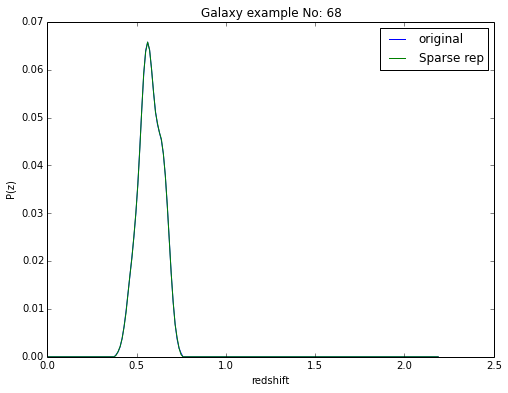

In [16]:
## Loading the files with the representation
plt.figure(figsize=(8,6))
F = pf.open('example_out.fits')
P = F[2].data.field('Sparse_indices')
F.close()

k = rn.sample(xrange(len(PO) - 1), 1)[0]
head = ps.read_header('example_out.fits') #To reconstrucy the dictionary
z = head['z']

rep_pdf = ps.reconstruct_pdf_int(P[k], head) #This function doesn't need to recreate the whole dictionary

plt.plot(z, PO[k] / sum(PO[k]), label='original')
plt.plot(z, rep_pdf/sum(rep_pdf), label='Sparse rep')
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.legend(loc=0)
title = 'Galaxy example No: %d' % k
plt.title(title)


#lets look at the basis

### Lets rebuild the dictionary with the parameters saved

In [17]:
head = ps.read_header('example_out.fits') # As before
D = ps.create_voigt_dict(head['z'], head['mu'], head['Nmu'], head['sig'], head['Nsig'], head['Nv']) 
print shape(D) ,' <-- shape of dictionary'
AA = linspace(0, 1, head['Ncoef'])
Da = AA[1] - AA[0]

(200, 60000)  <-- shape of dictionary


### Lets create another random example

In [18]:
### Lets recreate delat (the sparse vector)
delta = zeros(60000) ## All zeros but the 20 basis
k = rn.sample(xrange(len(PO) - 1), 1)[0] #random galaxy

print shape(delta), 'shape of sparse vector'
## lets split the integer, shift bits operations 
amplitudes, indices=ps.get_N(P[k])
#given the way we stored the data we need the following the get the sparse vector back
delta[indices] = Da*amplitudes
delta[indices[1:]] *= Da*amplitudes[0]

(60000,) shape of sparse vector


### Now we have $\mathbf{D}$ and $\mathbf{\delta}$

Then from the paper (see [intro](Sparse_intro.ipynb)), 

$$ \mathbf{pz}_k \approx \mathbf{D} \cdot \mathbf{\delta}_k $$

In [19]:
## lets take the dot product
r_pdf = dot(D, delta)

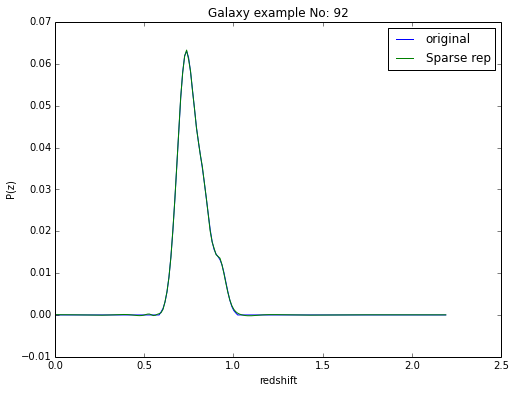

In [20]:
plt.figure(figsize=(8,6))
plt.plot(z, PO[k], label='original')
plt.plot(z, r_pdf, label='Sparse rep')
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.legend(loc=0)
title = 'Galaxy example No: %d' % k
plt.title(title)

### Same as before...

If you want to see the basis, then:

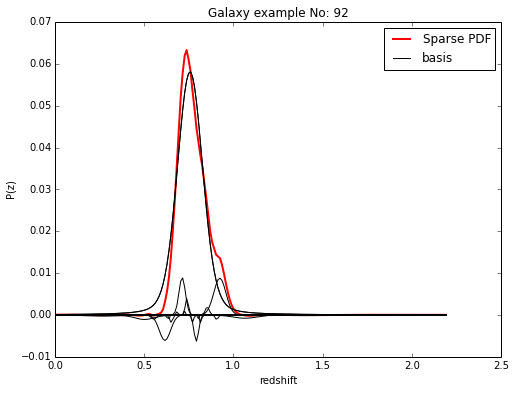

In [21]:
plt.figure(figsize=(8,6))
plt.plot(z, r_pdf, lw=2, color='red', label='Sparse PDF')
plt.plot(z, D[:,indices[0]]*delta[indices[0]],'k-', label='basis')
for i in indices:
    plt.plot(z, D[:,i]*delta[i],'k-') #plotting rach basis from D (non zero basis)
plt.xlabel('redshift')
plt.ylabel('P(z)')
plt.legend(loc=0)
title = 'Galaxy example No: %d' % k
plt.title(title)

The basis are shown in black lines, the reconstructed in red